Loaded datasets:
Cases: (3342, 1146)
Deaths: (3342, 1147)
✅ California COVID daily totals:
            total_cases  total_deaths
date                                 
2020-01-22            0             0
2020-01-23            0             0
2020-01-24            0             0
2020-01-25            0             0
2020-01-26            2             0
| Metric       |    Total |
|:-------------|---------:|
| Total Cases  | 12129699 |
| Total Deaths |   101159 |


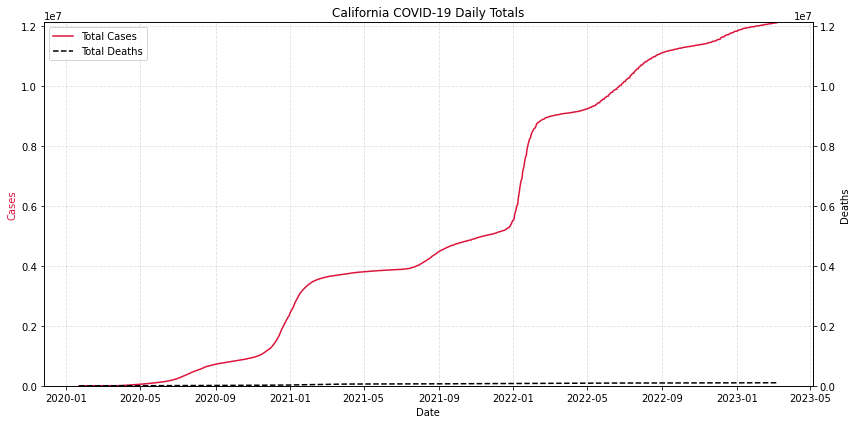

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import re

CA_STATE_NAME = "CALIFORNIA"

# 1. Load datasets
cov_cases = pd.read_csv("RAW_us_confirmed_cases.csv", low_memory=False)
cov_deaths = pd.read_csv("RAW_us_deaths.csv", low_memory=False)

print("Loaded datasets:")
print("Cases:", cov_cases.shape)
print("Deaths:", cov_deaths.shape)

# 2. Filter to California only
cov_cases = cov_cases[cov_cases['State'].astype(str).str.upper() == CA_STATE_NAME]
cov_deaths = cov_deaths[cov_deaths['State'].astype(str).str.upper() == CA_STATE_NAME]

# 3. Identify date columns
date_cols_cases = [c for c in cov_cases.columns if re.match(r'\d{1,2}/\d{1,2}/\d{4}', c)]
date_cols_deaths = [c for c in cov_deaths.columns if re.match(r'\d{1,2}/\d{1,2}/\d{4}', c)]

# 4. Convert and sum across counties
cov_cases[date_cols_cases] = cov_cases[date_cols_cases].apply(pd.to_numeric, errors='coerce').fillna(0)
cov_deaths[date_cols_deaths] = cov_deaths[date_cols_deaths].apply(pd.to_numeric, errors='coerce').fillna(0)

cases_daily = cov_cases[date_cols_cases].sum(axis=0).reset_index()
cases_daily.columns = ['date', 'total_cases']

deaths_daily = cov_deaths[date_cols_deaths].sum(axis=0).reset_index()
deaths_daily.columns = ['date', 'total_deaths']

# Convert to datetime and merge
cases_daily['date'] = pd.to_datetime(cases_daily['date'], errors='coerce')
deaths_daily['date'] = pd.to_datetime(deaths_daily['date'], errors='coerce')

covid_ca_daily = pd.merge(cases_daily, deaths_daily, on='date', how='inner').sort_values('date')
covid_ca_daily = covid_ca_daily.fillna(0)
covid_ca_daily = covid_ca_daily.set_index('date')

print("✅ California COVID daily totals:")
print(covid_ca_daily.head())

# ---------- Table of latest totals ----------
latest = covid_ca_daily.dropna().iloc[-1]
summary_table = pd.DataFrame({
    "Metric": ["Total Cases", "Total Deaths"],
    "Total": [int(latest['total_cases']), int(latest['total_deaths'])]
})
print(summary_table.to_markdown(index=False))

# ---------- DAILY Plot ----------
fig, ax1 = plt.subplots(figsize=(12,6))
cases_line, = ax1.plot(covid_ca_daily.index.to_numpy(), covid_ca_daily['total_cases'].to_numpy(),
                       color='crimson', label='Total Cases')
ax1.set_ylabel("Cases", color='crimson')
ax2 = ax1.twinx()
deaths_line, = ax2.plot(covid_ca_daily.index.to_numpy(), covid_ca_daily['total_deaths'].to_numpy(),
                        color='black', linestyle='--', label='Total Deaths')
ax2.set_ylabel("Deaths", color='black')
ymax = max(covid_ca_daily['total_cases'].max(), covid_ca_daily['total_deaths'].max())
ymin = min(covid_ca_daily['total_cases'].min(), covid_ca_daily['total_deaths'].min())
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)
ax1.set_title("California COVID-19 Daily Totals")
ax1.set_xlabel("Date")
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend([cases_line, deaths_line], ['Total Cases', 'Total Deaths'], loc='upper left')
plt.tight_layout()
plt.show()

In [23]:
# Calculate new cases/deaths per period
covid_ca_daily['new_cases'] = covid_ca_daily['total_cases'].diff().fillna(covid_ca_daily['total_cases'])
covid_ca_daily['new_deaths'] = covid_ca_daily['total_deaths'].diff().fillna(covid_ca_daily['total_deaths'])

In [24]:
covid_ca_weekly = covid_ca_daily[['new_cases', 'new_deaths']].resample('W').sum()
covid_ca_monthly = covid_ca_daily[['new_cases', 'new_deaths']].resample('ME').sum()
covid_ca_yearly = covid_ca_daily[['new_cases', 'new_deaths']].resample('YE').sum()


In [25]:
total_cases_ref = 12129699
total_deaths_ref = 101159

# Sums across all periods (should equal the final cumulative totals)
sum_new_cases_daily = int(covid_ca_daily['new_cases'].sum())
sum_new_deaths_daily = int(covid_ca_daily['new_deaths'].sum())
sum_new_cases_weekly = int(covid_ca_weekly['new_cases'].sum())
sum_new_deaths_weekly = int(covid_ca_weekly['new_deaths'].sum())
sum_new_cases_monthly = int(covid_ca_monthly['new_cases'].sum())
sum_new_deaths_monthly = int(covid_ca_monthly['new_deaths'].sum())
sum_new_cases_yearly = int(covid_ca_yearly['new_cases'].sum())
sum_new_deaths_yearly = int(covid_ca_yearly['new_deaths'].sum())

# Store for inspection
stored_totals = {
    "daily":   {"cases": sum_new_cases_daily,   "deaths": sum_new_deaths_daily},
    "weekly":  {"cases": sum_new_cases_weekly,  "deaths": sum_new_deaths_weekly},
    "monthly": {"cases": sum_new_cases_monthly, "deaths": sum_new_deaths_monthly},
    "yearly":  {"cases": sum_new_cases_yearly,  "deaths": sum_new_deaths_yearly},
}

In [26]:
# Daily increments (counts, not cumulative)
covid_cases_daily = covid_ca_daily['new_cases'].tolist()
covid_deaths_daily = covid_ca_daily['new_deaths'].tolist()

# Weekly increments (aligned to pandas Periods)
covid_cases_weekly = covid_ca_weekly['new_cases'].tolist()
covid_deaths_weekly = covid_ca_weekly['new_deaths'].tolist()

# Monthly increments
covid_cases_monthly = covid_ca_monthly['new_cases'].tolist()
covid_deaths_monthly = covid_ca_monthly['new_deaths'].tolist()

# Yearly increments
covid_cases_yearly = covid_ca_yearly['new_cases'].tolist()
covid_deaths_yearly = covid_ca_yearly['new_deaths'].tolist()



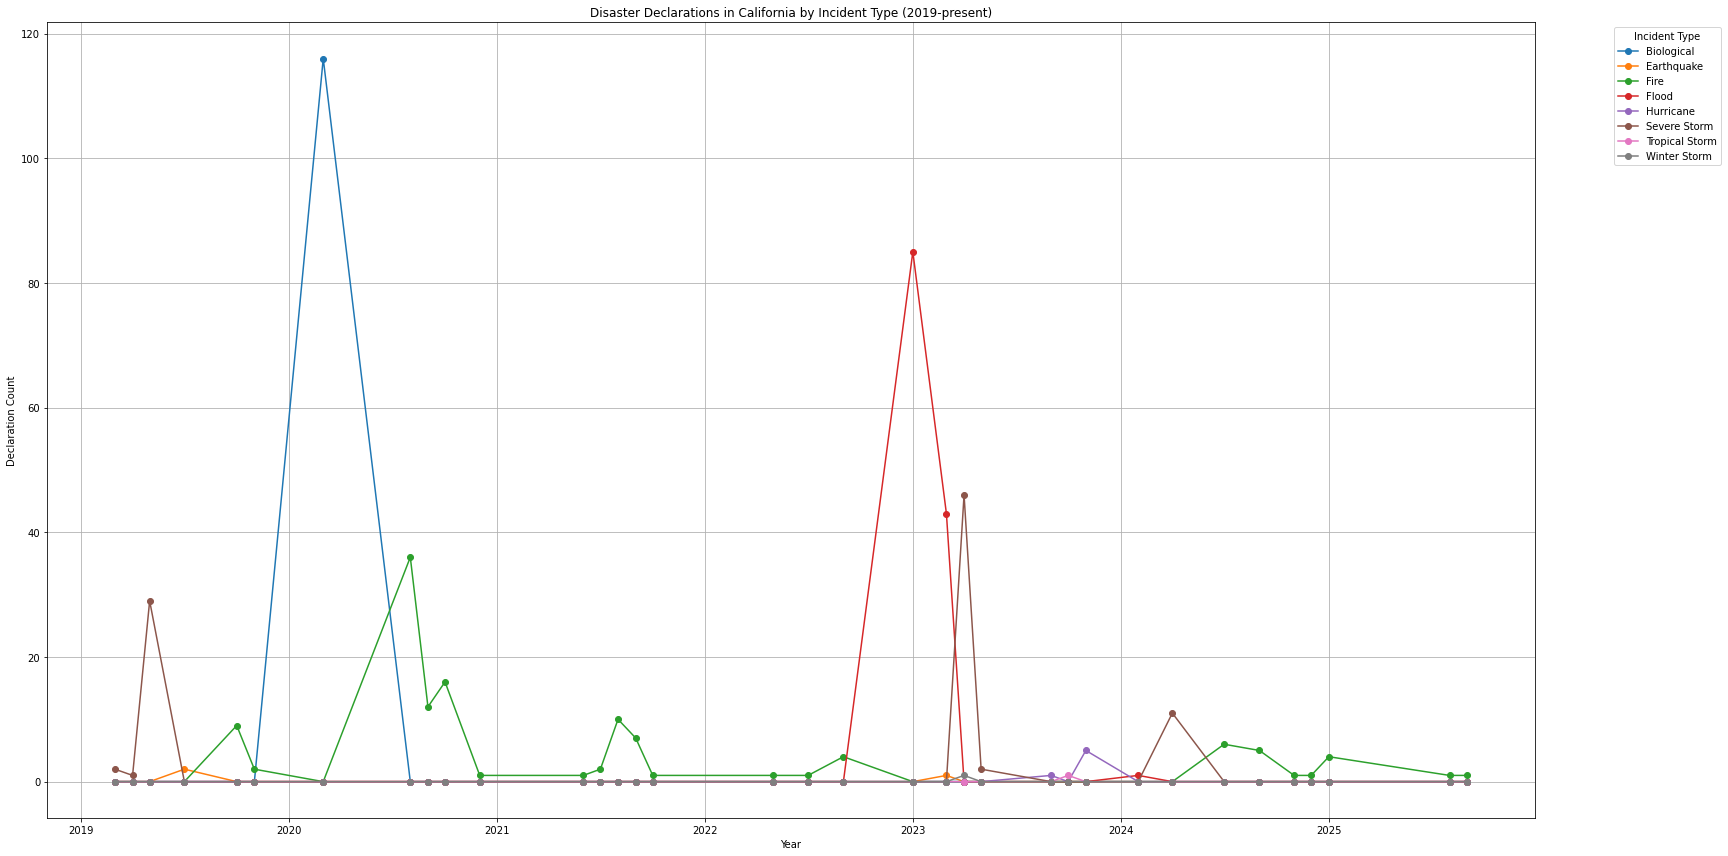

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("DisasterDeclarationsSummaries.csv")

# Filter for California
df_ca = df[df["State"] == "CA"].copy()

# Clean and standardize dates for declarationDate column
df_ca["declarationDate"] = pd.to_datetime(df_ca["declarationDate"], errors="coerce")

# Remove timezone information to make dates naive
df_ca["declarationDate"] = df_ca["declarationDate"].dt.tz_localize(None)

# Filter for records from 2019 onward
df_ca = df_ca[df_ca["declarationDate"] >= pd.Timestamp("2019-01-01")]

# Group by month and incidentType and count occurrences
grouped = df_ca.groupby([df_ca["declarationDate"].dt.to_period("M"), "incidentType"]).size().unstack(fill_value=0)
grouped.index = grouped.index.to_timestamp()

# Plot time series with separate lines for each incidentType
plt.figure(figsize=(24,12))
for incident_type in grouped.columns:
    plt.plot(grouped.index.to_numpy(), grouped[incident_type].values, marker='o', label=incident_type)

plt.title("Disaster Declarations in California by Incident Type (2019-present)")
plt.xlabel("Year")
plt.ylabel("Declaration Count")
plt.legend(title="Incident Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# Create a yearly count table for all disaster types
yearly_counts = df_ca.groupby(["Year", "incidentType"]).size().unstack(fill_value=0)

# Display the numerical table
print("\nDisaster Type Counts per Year in California:")
print(yearly_counts)


Disaster Type Counts per Year in California:
incidentType  Biological  Earthquake  Fire  Flood  Hurricane  Severe Storm  \
Year                                                                         
2019                   0           2     0      0          0            32   
2020                 116           0    59      0          0             0   
2021                   0           0    37      0          0             0   
2022                   0           0     7      0          0             0   
2023                   0           1     0    128          1            48   
2024                   0           0    11      1          5            11   
2025                   0           0     8      0          0             0   

incidentType  Tropical Storm  Winter Storm  
Year                                        
2019                       0             0  
2020                       0             0  
2021                       0             0  
2022                      

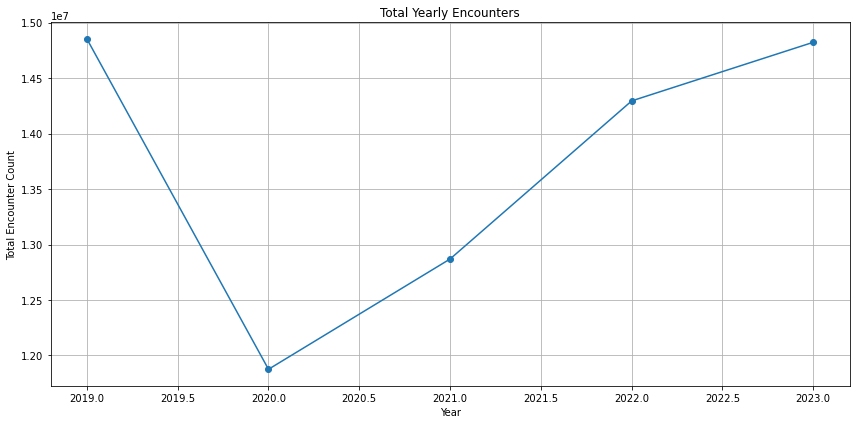

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load encounters dataset (2019+)
encounters_df = pd.read_csv("EncountersByFacility.csv")
encounters_df = encounters_df[encounters_df['Year'] >= 2019].copy()

# Fill NaNs in 'count' and convert to int
encounters_df['count'] = encounters_df['count'].fillna(0).astype(int)

# Aggregate total counts per year
yearly_counts = encounters_df.groupby('Year')['count'].sum()

# Plot yearly totals
plt.figure(figsize=(12,6))
plt.plot(yearly_counts.index.to_numpy(), yearly_counts.values, marker='o')
plt.title("Total Yearly Encounters")
plt.xlabel("Year")
plt.ylabel("Total Encounter Count")
plt.grid(True)
plt.tight_layout()
plt.show()


/storage/home/rnl5148/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/storage/home/rnl5148/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/storage/home/rnl5148/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/storage/home/rnl5148/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarni

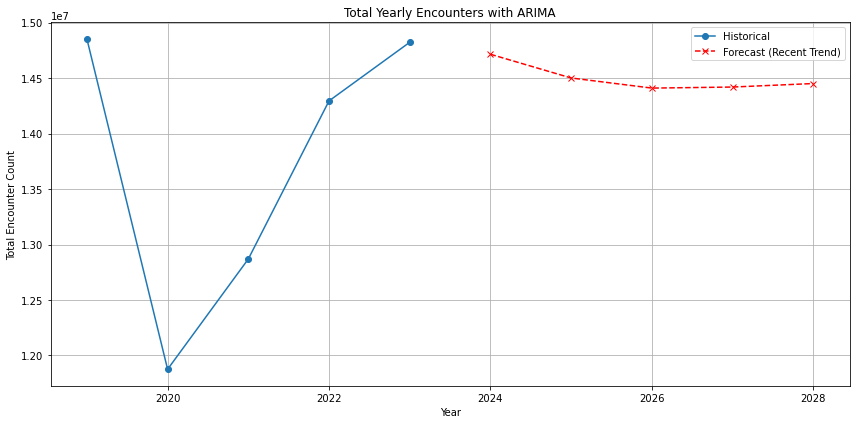

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Only use the N (e.g., 5) most recent years for trending
recent_years = 5
yearly_counts_recent = yearly_counts.tail(recent_years)

# Fit ARIMA on recent data, or try a higher-order AR component
model = ARIMA(yearly_counts_recent, order=(2,1,0))  # Example tweak
model_fit = model.fit()

# Forecast as before
forecast_years = 5
forecast = model_fit.forecast(steps=forecast_years)

# Get full year indices for forecast
last_year = yearly_counts_recent.index.max()
forecast_years_index = [last_year + i for i in range(1, forecast_years + 1)]

plt.figure(figsize=(12,6))
plt.plot(yearly_counts.index.to_numpy(), yearly_counts.values, marker='o', label='Historical')
plt.plot(forecast_years_index, forecast.to_numpy(), marker='x', linestyle='--', color='red', label='Forecast (Recent Trend)')
plt.title("Total Yearly Encounters with ARIMA")
plt.xlabel("Year")
plt.ylabel("Total Encounter Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Total Encounters Per Year (2019+):
   Year  Total Encounters
0  2019          14853783
1  2020          11875714
2  2021          12869895
3  2022          14295065
4  2023          14823516

Yearly Encounter Counts for ED_Admit vs ED_Visit (2019+):
type  Year  ED_Admit  ED_Visit
0     2019   2006473  12847310
1     2020   1851863  10023851
2     2021   1962045  10907850
3     2022   2015023  12280042
4     2023   2077082  12746434


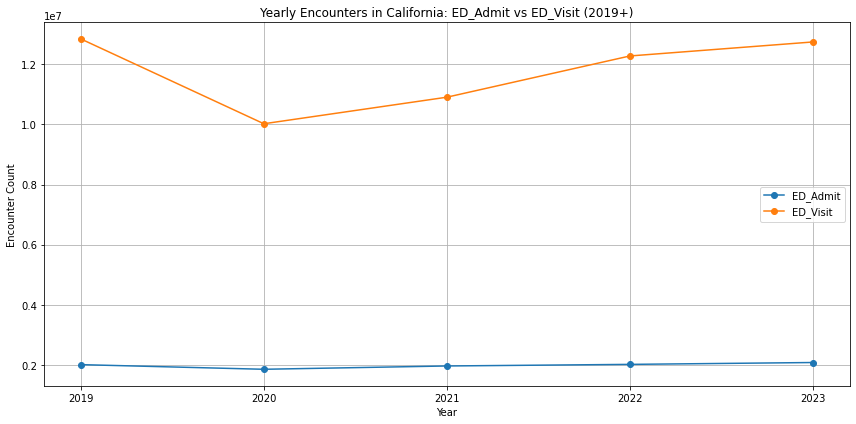

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load encounters dataset
enc_df = pd.read_csv("EncountersByFacility.csv")

# Filter to years 2019+
enc_df = enc_df[enc_df['Year'] >= 2019].copy()

# Fill NaNs and convert count to int
enc_df['count'] = enc_df['count'].fillna(0).astype(int)

# Total encounters per year
total_yearly = enc_df.groupby('Year')['count'].sum().reset_index(name='Total Encounters')

# Filter and aggregate ED_Admit and ED_Visit types
type_yearly = enc_df[enc_df['type'].isin(['ED_Admit', 'ED_Visit'])] \
    .groupby(['Year', 'type'])['count'].sum() \
    .unstack(fill_value=0).reset_index()

# Print numerical tables
print("Total Encounters Per Year (2019+):")
print(total_yearly)
print("\nYearly Encounter Counts for ED_Admit vs ED_Visit (2019+):")
print(type_yearly)

# Plot comparison time series
plt.figure(figsize=(12,6))
plt.plot(type_yearly['Year'].to_numpy(), type_yearly['ED_Admit'].to_numpy(), marker='o', label='ED_Admit')
plt.plot(type_yearly['Year'].to_numpy(), type_yearly['ED_Visit'].to_numpy(), marker='o', label='ED_Visit')

plt.title("Yearly Encounters in California: ED_Admit vs ED_Visit (2019+)")
plt.xlabel("Year")
plt.ylabel("Encounter Count")
plt.legend()
plt.grid(True)

# ✅ Force discrete ticks for each integer year
plt.xticks(type_yearly['Year'].to_numpy().astype(int))

plt.tight_layout()
plt.show()

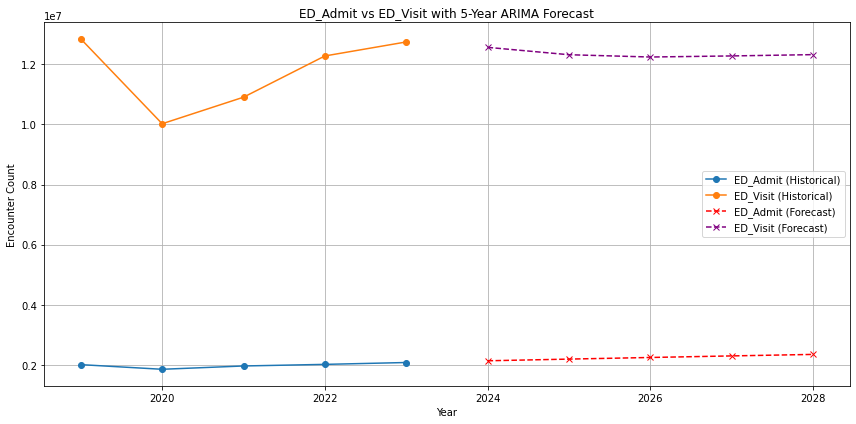

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load encounters dataset
enc_df = pd.read_csv("EncountersByFacility.csv")

# Filter to years 2019+
enc_df = enc_df[enc_df['Year'] >= 2019].copy()

# Fill NaNs and convert count to int
enc_df['count'] = enc_df['count'].fillna(0).astype(int)

# Filter and aggregate ED_Admit and ED_Visit types
type_yearly = enc_df[enc_df['type'].isin(['ED_Admit', 'ED_Visit'])] \
    .groupby(['Year', 'type'])['count'].sum().unstack(fill_value=0).reset_index()

# Example: focus on the last 5 years (can adjust as needed)
recent_n_years = 5
recent_years = type_yearly.tail(recent_n_years)

forecast_steps = 5

# Forecast for ED_Admit
model_admit = ARIMA(recent_years['ED_Admit'], order=(2,1,0))
fit_admit = model_admit.fit()
forecast_admit = fit_admit.forecast(steps=forecast_steps)
forecast_admit_years = [recent_years['Year'].iloc[-1] + i for i in range(1, forecast_steps+1)]

# Forecast for ED_Visit
model_visit = ARIMA(recent_years['ED_Visit'], order=(2,1,0))
fit_visit = model_visit.fit()
forecast_visit = fit_visit.forecast(steps=forecast_steps)
forecast_visit_years = [recent_years['Year'].iloc[-1] + i for i in range(1, forecast_steps+1)]

# Plot comparison and forecast
plt.figure(figsize=(12,6))
plt.plot(type_yearly['Year'].to_numpy(), type_yearly['ED_Admit'].to_numpy(), marker='o', label='ED_Admit (Historical)')
plt.plot(type_yearly['Year'].to_numpy(), type_yearly['ED_Visit'].to_numpy(), marker='o', label='ED_Visit (Historical)')

plt.plot(forecast_admit_years, forecast_admit.to_numpy(), marker='x', linestyle='--', color='red', label='ED_Admit (Forecast)')
plt.plot(forecast_visit_years, forecast_visit.to_numpy(), marker='x', linestyle='--', color='purple', label='ED_Visit (Forecast)')

plt.title("ED_Admit vs ED_Visit with 5-Year ARIMA Forecast")
plt.xlabel("Year")
plt.ylabel("Encounter Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# Load dataset
df = pd.read_csv("hadr-2023-2024.csv")

# List of columns expected numeric but might contain commas
numeric_cols = [
    'Hospital Full Time Staff', 'Nurse Full Time Staff', 'Productive Hours RNs',
    'Productive Hours LVNs', 'Productive Hours Aides', 'Count Hours RNs',
    'Productive Hours Ambulatory', 'Productive Hours Emergency',
    'Student Full Time', 'Beds Available', 'Operating Rooms'
]

# Remove commas and convert to numbers
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Summaries
total_full_time = df['Hospital Full Time Staff'].sum()
total_nurse_full_time = df['Nurse Full Time Staff'].sum()
rn_hours_sum = df['Productive Hours RNs'].sum()
lvn_hours_sum = df['Productive Hours LVNs'].sum()
aide_hours_sum = df['Productive Hours Aides'].sum()
count_hours_rns_sum = df['Count Hours RNs'].sum()
prod_hours_ambulatory_sum = df['Productive Hours Ambulatory'].sum()
prod_hours_emergency_sum = df['Productive Hours Emergency'].sum()
student_full_time_sum = df['Student Full Time'].sum()
total_beds = df['Beds Available'].sum()
total_operating_rooms = df['Operating Rooms'].sum()

# Print summary
print(f"Total Hospital Full Time Staff: {total_full_time:,.0f}")
print(f"Total Nurse Full Time Staff: {total_nurse_full_time:,.0f}")
print(f"Total Productive Hours RNs: {rn_hours_sum:,.0f}")
print(f"Total Productive Hours LVNs: {lvn_hours_sum:,.0f}")
print(f"Total Productive Hours Aides: {aide_hours_sum:,.0f}")
print(f"Total Count Hours RNs: {count_hours_rns_sum:,.0f}")
print(f"Total Productive Hours Ambulatory: {prod_hours_ambulatory_sum:,.0f}")
print(f"Total Productive Hours Emergency: {prod_hours_emergency_sum:,.0f}")
print(f"Total Student Full Time: {student_full_time_sum:,.0f}")
print(f"Total Beds Available: {total_beds:,.0f}")
print(f"Total Operating Rooms: {total_operating_rooms:,.0f}")

Total Hospital Full Time Staff: 504,275
Total Nurse Full Time Staff: 181,911
Total Productive Hours RNs: 263,407,281
Total Productive Hours LVNs: 13,680,381
Total Productive Hours Aides: 73,234,241
Total Count Hours RNs: 28,164,418
Total Productive Hours Ambulatory: 119,872,496
Total Productive Hours Emergency: 24,535,152
Total Student Full Time: 16,540
Total Beds Available: 93,838
Total Operating Rooms: 3,244


Staff per Encounter: 0.0340
Beds per Encounter: 0.0063
Hours per Encounter: 18.6924


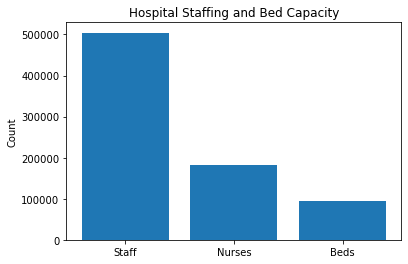

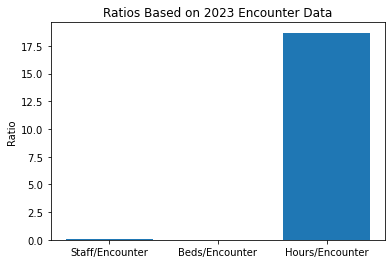

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("hadr-2023-2024.csv")

# Clean numeric columns
numeric_cols = [
    'Hospital Full Time Staff', 'Nurse Full Time Staff', 'Productive Hours RNs',
    'Productive Hours LVNs', 'Productive Hours Aides', 'Count Hours RNs',
    'Productive Hours Ambulatory', 'Productive Hours Emergency',
    'Beds Available', 'Operating Rooms'
]
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Calculate totals
total_encounters_2023 = 14823516
total_ED_admit_2023 = 2077082
total_ED_visit_2023 = 12746434

# Sum staffing and beds
total_staff = df['Hospital Full Time Staff'].sum()
total_nurses = df['Nurse Full Time Staff'].sum()
total_beds = df['Beds Available'].sum()
total_hours = df['Productive Hours RNs'].sum() + df['Productive Hours LVNs'].sum()

# Ratios
staff_per_encounter = total_staff / total_encounters_2023
beds_per_encounter = total_beds / total_encounters_2023
hours_per_encounter = total_hours / total_encounters_2023

print(f"Staff per Encounter: {staff_per_encounter:.4f}")
print(f"Beds per Encounter: {beds_per_encounter:.4f}")
print(f"Hours per Encounter: {hours_per_encounter:.4f}")

# Visualization - Bar chart of staffing and beds
plt.bar(["Staff", "Nurses", "Beds"], [total_staff, total_nurses, total_beds])
plt.title("Hospital Staffing and Bed Capacity")
plt.ylabel("Count")
plt.show()

# Visualization - Ratios
plt.figure()
plt.bar(["Staff/Encounter", "Beds/Encounter", "Hours/Encounter"],
        [staff_per_encounter, beds_per_encounter, hours_per_encounter])
plt.title("Ratios Based on 2023 Encounter Data")
plt.ylabel("Ratio")
plt.show()

In [49]:
staff_per_bed = total_staff / total_beds
print("Staff Per Bed:", staff_per_bed)
nurse_per_bed = total_nurses / total_beds
print("Nurses Per Bed:", nurse_per_bed)
rn_hours_per_bed = df['Productive Hours RNs'].sum() / total_beds
print("Hours Per Bed:", rn_hours_per_bed)

Staff Per Bed: 5.373889042818474
Nurses Per Bed: 1.9385643342782242
Hours Per Bed: 2807.042786504401


In [40]:
hours_per_staff = total_hours / total_staff
print(f"Average productive hours per staff: {hours_per_staff:.2f}")

Average productive hours per staff: 549.48


In [54]:
df['Staff per Bed'] = df['Hospital Full Time Staff'] / df['Beds Available']
df['Nurse per Staff'] = df['Nurse Full Time Staff'] / df['Hospital Full Time Staff']
facility_summary = df.groupby('Hospital')[['Staff per Bed', 'Nurse per Staff']].mean()
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
print(facility_summary)

                                                    Staff per Bed  \
Hospital                                                            
ADVENTIST HEALTH AND RIDEOUT                             5.583710   
ADVENTIST HEALTH BAKERSFIELD                             6.181102   
ADVENTIST HEALTH CLEARLAKE                              26.560000   
ADVENTIST HEALTH DELANO                                  2.493590   
ADVENTIST HEALTH GLENDALE                                3.988914   
...                                                           ...   
WEST ANAHEIM MEDICAL CENTER                              3.146119   
WEST HILLS HOSPITAL AND MEDICAL CENTER                   1.626923   
WHITTIER HOSPITAL MEDICAL CENTER                         3.729730   
WOODLAND MEMORIAL HOSPITAL                               5.304762   
ZUCKERBERG SAN FRANCISCO GENERAL HOSPITAL & TRA...       7.711392   

                                                    Nurse per Staff  
Hospital                        

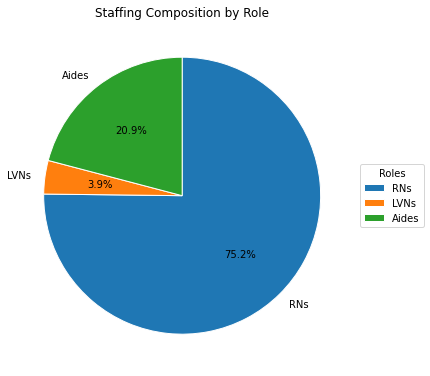

In [56]:
staff_mix = {
    'RNs': df['Productive Hours RNs'].sum(),
    'LVNs': df['Productive Hours LVNs'].sum(),
    'Aides': df['Productive Hours Aides'].sum()
}

fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    staff_mix.values(),
    labels=staff_mix.keys(),
    autopct='%1.1f%%',
    startangle=90,       # rotate so the first slice starts at top
    counterclock=False,  # makes order clockwise
    wedgeprops={'edgecolor': 'white'}  # cleaner slice edges
)

ax.set_title("Staffing Composition by Role")

# Add legend on the right side
ax.legend(
    wedges,
    staff_mix.keys(),
    title="Roles",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


Productive Hours RNs prediction MSE: 9,837,024,059.50
Productive Hours LVNs prediction MSE: 539,331,016.67
Productive Hours Aides prediction MSE: 3,507,779,119.30

Predicted Total Productive Hours (2023):
  RNs:   263,489,304
  LVNs:  13,581,879
  Aides: 71,264,933
  TOTAL: 348,336,116
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /storage/home/rnl5148/.local/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/4e4b747fd3a4415faac5a6d0e844e256-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/4e4b747fd3a4415faac5a6d0e844e256-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 15 RHS
At line 19 BOUNDS
At line 20 ENDATA
Problem MODEL has 3 rows, 3 columns and 3 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-3) rows, 0 (-3) columns and 0 (-3) elements
Empty problem - 0 rows, 0 columns and 0 elements

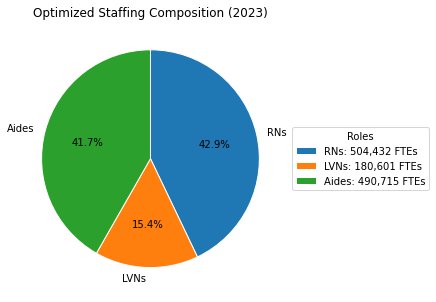

In [58]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus

# ------------------------------
# 1. Load and clean data
# ------------------------------
df = pd.read_csv("hadr-2023-2024.csv")

numeric_cols = [
    'Hospital Full Time Staff', 'Nurse Full Time Staff', 'Productive Hours RNs',
    'Productive Hours LVNs', 'Productive Hours Aides', 'Productive Hours Ambulatory',
    'Productive Hours Emergency', 'Beds Available', 'Operating Rooms'
]
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# ------------------------------
# 2. Add Encounter Data (2023 totals)
# ------------------------------
total_encounters_2023 = 14823516
total_ED_admit_2023 = 2077082
total_ED_visit_2023 = 12746434

# Add encounter columns for context
df['Total Encounters'] = total_encounters_2023
df['ED Admits'] = total_ED_admit_2023
df['ED Visits'] = total_ED_visit_2023

# ------------------------------
# 3. Feature Engineering
# ------------------------------
df['Staff per Bed'] = df['Hospital Full Time Staff'] / (df['Beds Available'] + 1)
df['Nurses per Bed'] = df['Nurse Full Time Staff'] / (df['Beds Available'] + 1)
df['RN Hours per Bed'] = df['Productive Hours RNs'] / (df['Beds Available'] + 1)
df['LVN Hours per Bed'] = df['Productive Hours LVNs'] / (df['Beds Available'] + 1)
df['Aide Hours per Bed'] = df['Productive Hours Aides'] / (df['Beds Available'] + 1)

# Fill missing values
df.fillna(0, inplace=True)

# Features and targets
features = ['Beds Available', 'Operating Rooms', 'Hospital Full Time Staff', 'Nurse Full Time Staff']
target_cols = ['Productive Hours RNs', 'Productive Hours LVNs', 'Productive Hours Aides']

# ------------------------------
# 4. Train Predictive Models
# ------------------------------
models = {}
predictions = pd.DataFrame(index=df.index)

for target in target_cols:
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(df[features])
    predictions[target] = y_pred
    models[target] = model
    mse = mean_squared_error(df[target], y_pred)
    print(f"{target} prediction MSE: {mse:,.2f}")

# ------------------------------
# 5. Aggregate Predicted Totals (2023)
# ------------------------------
pred_RN_hours = predictions['Productive Hours RNs'].sum()
pred_LVN_hours = predictions['Productive Hours LVNs'].sum()
pred_Aide_hours = predictions['Productive Hours Aides'].sum()
total_pred_hours = pred_RN_hours + pred_LVN_hours + pred_Aide_hours

print("\nPredicted Total Productive Hours (2023):")
print(f"  RNs:   {pred_RN_hours:,.0f}")
print(f"  LVNs:  {pred_LVN_hours:,.0f}")
print(f"  Aides: {pred_Aide_hours:,.0f}")
print(f"  TOTAL: {total_pred_hours:,.0f}")

# ------------------------------
# 6. Staffing Optimization (Linear Programming)
# ------------------------------
# Estimate average productive hours per FTE from data
avg_RN_hours_per_staff = df['Productive Hours RNs'].sum() / df['Hospital Full Time Staff'].sum()
avg_LVN_hours_per_staff = df['Productive Hours LVNs'].sum() / df['Nurse Full Time Staff'].sum()
avg_Aide_hours_per_staff = df['Productive Hours Aides'].sum() / df['Hospital Full Time Staff'].sum()

# LP setup
prob = LpProblem("Staffing_Optimization", LpMinimize)

RN_staff = LpVariable("RN_staff", lowBound=0)
LVN_staff = LpVariable("LVN_staff", lowBound=0)
Aide_staff = LpVariable("Aide_staff", lowBound=0)

# Objective: minimize total FTEs
prob += RN_staff + LVN_staff + Aide_staff

# Constraints: meet total predicted workload
prob += RN_staff * avg_RN_hours_per_staff >= pred_RN_hours
prob += LVN_staff * avg_LVN_hours_per_staff >= pred_LVN_hours
prob += Aide_staff * avg_Aide_hours_per_staff >= pred_Aide_hours

# Solve
prob.solve()
print("\nOptimization Status:", LpStatus[prob.status])
print("Recommended Staffing Mix (2023):")
print(f"  RNs:   {RN_staff.varValue:,.0f} FTEs")
print(f"  LVNs:  {LVN_staff.varValue:,.0f} FTEs")
print(f"  Aides: {Aide_staff.varValue:,.0f} FTEs")

# ------------------------------
# 7. Visualization
# ------------------------------
staff_mix = {
    'RNs': RN_staff.varValue,
    'LVNs': LVN_staff.varValue,
    'Aides': Aide_staff.varValue
}

fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    staff_mix.values(),
    labels=staff_mix.keys(),
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor':'white'}
)

ax.set_title("Optimized Staffing Composition (2023)")
ax.legend(wedges, [f"{k}: {v:,.0f} FTEs" for k, v in staff_mix.items()],
          title="Roles", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
